In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder

In [196]:
data = pd.read_csv('202201/curr_udplatency.csv')

In [157]:
data.head()

,unit_id,dtime,target,rtt_avg,rtt_min,rtt_max,rtt_std,successes,failures
0,22,2022-01-01 00:28:36,sp2-vm-newyork-us.samknows.com,17906,14043,27800,1651,711,0
1,22,2022-01-01 00:28:36,newyorkfcc.west.verizon.net,18635,16657,33193,2429,711,0
2,22,2022-01-01 00:52:23,sp2-vm-newyork-us.samknows.com,18074,14834,26625,1569,220,0
3,22,2022-01-01 00:52:23,newyorkfcc.west.verizon.net,19000,16714,29388,2542,220,0
4,22,2022-01-01 01:28:34,sp1-vm-newyork-us.samknows.com,18359,13986,33229,2249,271,0


In [202]:
data.shape

(6023080, 9)

In [4]:
len(data['target'].unique().tolist())

92

## Cluster based on the features - target and rtt_avg

#### find optimum value of K

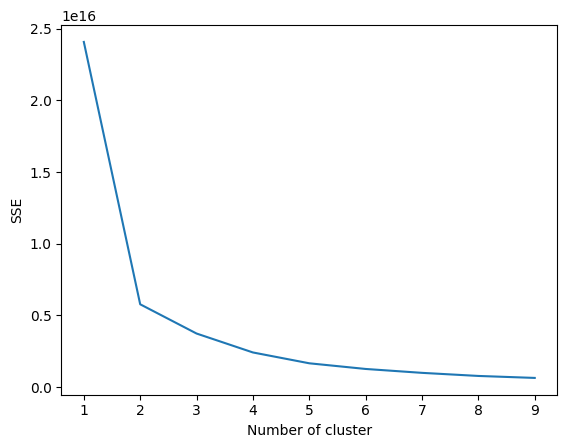

In [175]:
targets = data['target']
le = LabelEncoder()
data['target'] = le.fit_transform(data['target'])
X = data[['target', 'rtt_avg']].to_numpy()

sse = {}
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000, random_state=0, n_init="auto").fit(X)
    # data["Cluster"] = kmeans.labels_
    #print(data["clusters"])
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

#### select k=5 and make analyze the clusters

In [176]:
kmeans = KMeans(n_clusters=5, max_iter=1000, random_state=0, n_init="auto").fit(X)
data_copy = data.copy(deep=True)
data_copy['Cluster'] = kmeans.labels_

unit_id_map = pd.read_csv('202201/unit_id_mapping.csv')
merged_data = pd.merge(data_copy, unit_id_map, how="left", on="unit_id")
merged_data['operator_name'] = pd.Categorical(merged_data.operator_name)
merged_data['operator_technology'] = pd.Categorical(merged_data.operator_technology)
merged_data.head()

,unit_id,dtime,target,rtt_avg,rtt_min,rtt_max,rtt_std,successes,failures,Cluster,operator_name,operator_technology
0,22,2022-01-01 00:28:36,84,17906,14043,27800,1651,711,0,0,Verizon,Fiber
1,22,2022-01-01 00:28:36,49,18635,16657,33193,2429,711,0,0,Verizon,Fiber
2,22,2022-01-01 00:52:23,84,18074,14834,26625,1569,220,0,0,Verizon,Fiber
3,22,2022-01-01 00:52:23,49,19000,16714,29388,2542,220,0,0,Verizon,Fiber
4,22,2022-01-01 01:28:34,79,18359,13986,33229,2249,271,0,0,Verizon,Fiber


### Summary based on Operator

In [177]:
from functools import reduce
op_stats_0 = merged_data[merged_data["Cluster"] == 0].groupby(["operator_name"])["operator_name"].count().sort_values(ascending=False).reset_index(name="Cluster 0")
op_stats_1 = merged_data[merged_data["Cluster"] == 1].groupby(["operator_name"])["operator_name"].count().sort_values(ascending=False).reset_index(name="Cluster 1")
op_stats_2 = merged_data[merged_data["Cluster"] == 2].groupby(["operator_name"])["operator_name"].count().sort_values(ascending=False).reset_index(name="Cluster 2")
op_stats_3 = merged_data[merged_data["Cluster"] == 3].groupby(["operator_name"])["operator_name"].count().sort_values(ascending=False).reset_index(name="Cluster 3")
op_stats_4 = merged_data[merged_data["Cluster"] == 4].groupby(["operator_name"])["operator_name"].count().sort_values(ascending=False).reset_index(name="Cluster 4")
all_op_stats = [op_stats_0, op_stats_1, op_stats_2, op_stats_3, op_stats_4]

op_stats = reduce(lambda df_left, df_right: pd.merge(df_left, df_right, how='outer', on='operator_name'), all_op_stats).fillna(0)
op_stats.loc['Total'] = op_stats[['Cluster 0','Cluster 1','Cluster 2','Cluster 3','Cluster 4',]].sum()
print(op_stats.to_markdown(tablefmt="grid", floatfmt='.0f'))

+-------+------------------+-------------+-------------+-------------+-------------+-------------+
|       | operator_name    |   Cluster 0 |   Cluster 1 |   Cluster 2 |   Cluster 3 |   Cluster 4 |
+=======+==================+=============+=============+=============+=============+=============+
| 0     | Comcast          |      906467 |        2576 |       11985 |         395 |        3728 |
+-------+------------------+-------------+-------------+-------------+-------------+-------------+
| 1     | Charter          |      711663 |         203 |       79689 |          11 |        1160 |
+-------+------------------+-------------+-------------+-------------+-------------+-------------+
| 2     | Frontier         |      653309 |        2616 |       58429 |        1220 |        4457 |
+-------+------------------+-------------+-------------+-------------+-------------+-------------+
| 3     | CenturyLink      |      585758 |        2129 |      526608 |         821 |       13311 |
+-------+-

### Summary Based on Technology

In [178]:
from functools import reduce
op_stats_0 = merged_data[merged_data["Cluster"] == 0].groupby(["operator_technology"])["operator_technology"].count().sort_values(ascending=False).reset_index(name="Cluster 0")
op_stats_1 = merged_data[merged_data["Cluster"] == 1].groupby(["operator_technology"])["operator_technology"].count().sort_values(ascending=False).reset_index(name="Cluster 1")
op_stats_2 = merged_data[merged_data["Cluster"] == 2].groupby(["operator_technology"])["operator_technology"].count().sort_values(ascending=False).reset_index(name="Cluster 2")
op_stats_3 = merged_data[merged_data["Cluster"] == 3].groupby(["operator_technology"])["operator_technology"].count().sort_values(ascending=False).reset_index(name="Cluster 3")
op_stats_4 = merged_data[merged_data["Cluster"] == 4].groupby(["operator_technology"])["operator_technology"].count().sort_values(ascending=False).reset_index(name="Cluster 4")
all_op_stats = [op_stats_0, op_stats_1, op_stats_2, op_stats_3, op_stats_4]

op_stats = reduce(lambda df_left, df_right: pd.merge(df_left, df_right, how='outer', on='operator_technology'), all_op_stats).fillna(0)
op_stats.loc['Total'] = op_stats[['Cluster 0','Cluster 1','Cluster 2','Cluster 3','Cluster 4',]].sum()
print(op_stats.to_markdown(tablefmt="grid", floatfmt='.0f'))

+-------+-----------------------+-------------+-------------+-------------+-------------+-------------+
|       | operator_technology   |   Cluster 0 |   Cluster 1 |   Cluster 2 |   Cluster 3 |   Cluster 4 |
+=======+=======================+=============+=============+=============+=============+=============+
| 0     | Cable                 |     2187332 |        3041 |      129520 |        1031 |        5434 |
+-------+-----------------------+-------------+-------------+-------------+-------------+-------------+
| 1     | Fiber                 |     1229964 |         229 |       67406 |         102 |        2310 |
+-------+-----------------------+-------------+-------------+-------------+-------------+-------------+
| 2     | DSL                   |     1058592 |        5358 |      577340 |        2322 |       20327 |
+-------+-----------------------+-------------+-------------+-------------+-------------+-------------+
| 3     | Fixed Wireless        |         412 |           0 |   

### Summary based on rtt_avg

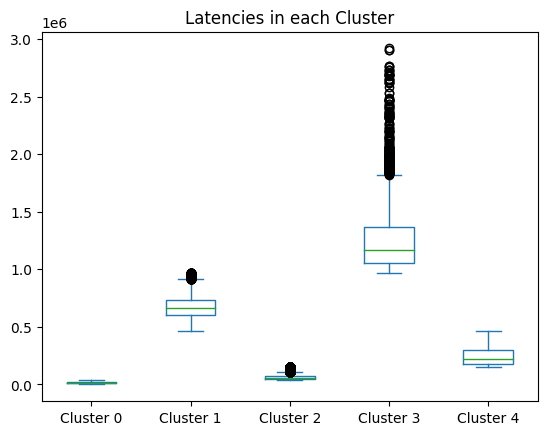

In [183]:
cluster_0 = merged_data[merged_data["Cluster"] == 0]
cluster_1 = merged_data[merged_data["Cluster"] == 1]
cluster_2 = merged_data[merged_data["Cluster"] == 2]
cluster_3 = merged_data[merged_data["Cluster"] == 3]
cluster_4 = merged_data[merged_data["Cluster"] == 4]
all_clusters = pd.concat([cluster_0['rtt_avg'], cluster_1['rtt_avg'], cluster_2['rtt_avg'], cluster_3['rtt_avg'], cluster_4['rtt_avg']], axis=1)
all_clusters.columns = ['Cluster 0','Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4']
all_clusters.plot(kind="box", title="Latencies in each Cluster")
plt.show()

# ax = cluster_0[['rtt_avg']].plot(kind="box")
# plt.hist(latencies)

## Cluster based on the features - rtt_avg, rtt_max, rtt_min

#### find optimum value of K

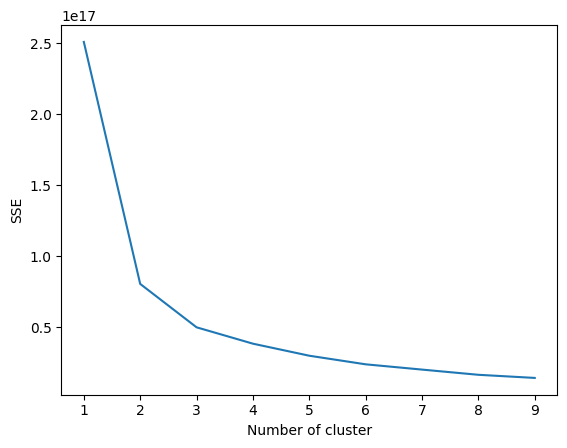

In [191]:
# targets = data['target']
# le = LabelEncoder()
# data['target'] = le.fit_transform(data['target'])
X = data[['rtt_min', 'rtt_avg', 'rtt_max']].to_numpy()

sse = {}
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000, random_state=0, n_init="auto").fit(X)
    # data["Cluster"] = kmeans.labels_
    #print(data["clusters"])
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

#### select k=6 and make analyze the clusters

In [192]:
kmeans = KMeans(n_clusters=6, max_iter=1000, random_state=0, n_init="auto").fit(X)
data_copy = data.copy(deep=True)
data_copy['Cluster'] = kmeans.labels_

unit_id_map = pd.read_csv('202201/unit_id_mapping.csv')
merged_data = pd.merge(data_copy, unit_id_map, how="left", on="unit_id")
merged_data['operator_name'] = pd.Categorical(merged_data.operator_name)
merged_data['operator_technology'] = pd.Categorical(merged_data.operator_technology)
merged_data.head()

,unit_id,dtime,target,rtt_avg,rtt_min,rtt_max,rtt_std,successes,failures,Cluster,operator_name,operator_technology
0,22,2022-01-01 00:28:36,sp2-vm-newyork-us.samknows.com,17906,14043,27800,1651,711,0,0,Verizon,Fiber
1,22,2022-01-01 00:28:36,newyorkfcc.west.verizon.net,18635,16657,33193,2429,711,0,0,Verizon,Fiber
2,22,2022-01-01 00:52:23,sp2-vm-newyork-us.samknows.com,18074,14834,26625,1569,220,0,0,Verizon,Fiber
3,22,2022-01-01 00:52:23,newyorkfcc.west.verizon.net,19000,16714,29388,2542,220,0,0,Verizon,Fiber
4,22,2022-01-01 01:28:34,sp1-vm-newyork-us.samknows.com,18359,13986,33229,2249,271,0,0,Verizon,Fiber


### Summary based on Operator

In [193]:
from functools import reduce
op_stats_0 = merged_data[merged_data["Cluster"] == 0].groupby(["operator_name"])["operator_name"].count().sort_values(ascending=False).reset_index(name="Cluster 0")
op_stats_1 = merged_data[merged_data["Cluster"] == 1].groupby(["operator_name"])["operator_name"].count().sort_values(ascending=False).reset_index(name="Cluster 1")
op_stats_2 = merged_data[merged_data["Cluster"] == 2].groupby(["operator_name"])["operator_name"].count().sort_values(ascending=False).reset_index(name="Cluster 2")
op_stats_3 = merged_data[merged_data["Cluster"] == 3].groupby(["operator_name"])["operator_name"].count().sort_values(ascending=False).reset_index(name="Cluster 3")
op_stats_4 = merged_data[merged_data["Cluster"] == 4].groupby(["operator_name"])["operator_name"].count().sort_values(ascending=False).reset_index(name="Cluster 4")
op_stats_5 = merged_data[merged_data["Cluster"] == 5].groupby(["operator_name"])["operator_name"].count().sort_values(ascending=False).reset_index(name="Cluster 5")
all_op_stats = [op_stats_0, op_stats_1, op_stats_2, op_stats_3, op_stats_4, op_stats_5]

op_stats = reduce(lambda df_left, df_right: pd.merge(df_left, df_right, how='outer', on='operator_name'), all_op_stats).fillna(0)
op_stats.loc['Total'] = op_stats[['Cluster 0','Cluster 1','Cluster 2','Cluster 3','Cluster 4','Cluster 5']].sum()
print(op_stats.to_markdown(tablefmt="grid", floatfmt='.0f'))

+-------+------------------+-------------+-------------+-------------+-------------+-------------+-------------+
|       | operator_name    |   Cluster 0 |   Cluster 1 |   Cluster 2 |   Cluster 3 |   Cluster 4 |   Cluster 5 |
+=======+==================+=============+=============+=============+=============+=============+=============+
| 0     | Comcast          |      896674 |        1868 |        4809 |       16079 |        5635 |          86 |
+-------+------------------+-------------+-------------+-------------+-------------+-------------+-------------+
| 1     | CenturyLink      |      778024 |        4451 |       32403 |      301934 |       11249 |         566 |
+-------+------------------+-------------+-------------+-------------+-------------+-------------+-------------+
| 2     | Charter          |      694862 |         467 |        4458 |       91897 |        1026 |          16 |
+-------+------------------+-------------+-------------+-------------+-------------+------------

### Summary Based on Technology

In [194]:
from functools import reduce
op_stats_0 = merged_data[merged_data["Cluster"] == 0].groupby(["operator_technology"])["operator_technology"].count().sort_values(ascending=False).reset_index(name="Cluster 0")
op_stats_1 = merged_data[merged_data["Cluster"] == 1].groupby(["operator_technology"])["operator_technology"].count().sort_values(ascending=False).reset_index(name="Cluster 1")
op_stats_2 = merged_data[merged_data["Cluster"] == 2].groupby(["operator_technology"])["operator_technology"].count().sort_values(ascending=False).reset_index(name="Cluster 2")
op_stats_3 = merged_data[merged_data["Cluster"] == 3].groupby(["operator_technology"])["operator_technology"].count().sort_values(ascending=False).reset_index(name="Cluster 3")
op_stats_4 = merged_data[merged_data["Cluster"] == 4].groupby(["operator_technology"])["operator_technology"].count().sort_values(ascending=False).reset_index(name="Cluster 4")
op_stats_5 = merged_data[merged_data["Cluster"] == 5].groupby(["operator_technology"])["operator_technology"].count().sort_values(ascending=False).reset_index(name="Cluster 5")
all_op_stats = [op_stats_0, op_stats_1, op_stats_2, op_stats_3, op_stats_4, op_stats_5]

op_stats = reduce(lambda df_left, df_right: pd.merge(df_left, df_right, how='outer', on='operator_technology'), all_op_stats).fillna(0)
op_stats.loc['Total'] = op_stats[['Cluster 0','Cluster 1','Cluster 2','Cluster 3','Cluster 4','Cluster 5']].sum()
print(op_stats.to_markdown(tablefmt="grid", floatfmt='.0f'))

+-------+-----------------------+-------------+-------------+-------------+-------------+-------------+-------------+
|       | operator_technology   |   Cluster 0 |   Cluster 1 |   Cluster 2 |   Cluster 3 |   Cluster 4 |   Cluster 5 |
+=======+=======================+=============+=============+=============+=============+=============+=============+
| 0     | Cable                 |     2169884 |        2778 |       11568 |      134301 |        7284 |         543 |
+-------+-----------------------+-------------+-------------+-------------+-------------+-------------+-------------+
| 1     | Fiber                 |     1267584 |         472 |        6083 |       24234 |        1577 |          61 |
+-------+-----------------------+-------------+-------------+-------------+-------------+-------------+-------------+
| 2     | DSL                   |     1204208 |        8403 |       56476 |      374613 |       17717 |        2522 |
+-------+-----------------------+-------------+---------

### Summary based on rtt_avg

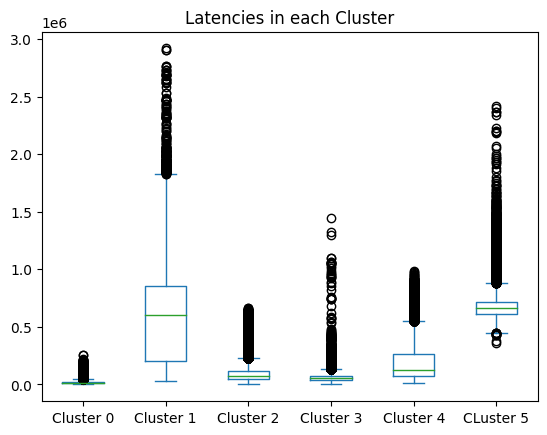

In [195]:
cluster_0 = merged_data[merged_data["Cluster"] == 0]
cluster_1 = merged_data[merged_data["Cluster"] == 1]
cluster_2 = merged_data[merged_data["Cluster"] == 2]
cluster_3 = merged_data[merged_data["Cluster"] == 3]
cluster_4 = merged_data[merged_data["Cluster"] == 4]
cluster_5 = merged_data[merged_data["Cluster"] == 5]
all_clusters = pd.concat([cluster_0['rtt_avg'], cluster_1['rtt_avg'], cluster_2['rtt_avg'], cluster_3['rtt_avg'], cluster_4['rtt_avg'], cluster_5['rtt_avg']], axis=1)
all_clusters.columns = ['Cluster 0','Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4', 'CLuster 5']
all_clusters.plot(kind="box", title="Latencies in each Cluster")
plt.show()

# ax = cluster_0[['rtt_avg']].plot(kind="box")
# plt.hist(latencies)

## Cluster based on the features - target, rtt_min, rtt_avg, rtt_max

#### find optimum value of K

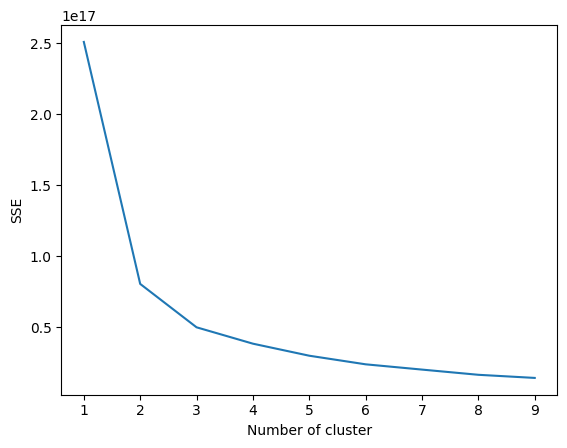

In [197]:
targets = data['target']
le = LabelEncoder()
data['target'] = le.fit_transform(data['target'])
X = data[['target', 'rtt_min', 'rtt_avg', 'rtt_max']].to_numpy()

sse = {}
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000, random_state=0, n_init="auto").fit(X)
    # data["Cluster"] = kmeans.labels_
    #print(data["clusters"])
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

#### select k=6 and make analyze the clusters

In [198]:
kmeans = KMeans(n_clusters=6, max_iter=1000, random_state=0, n_init="auto").fit(X)
data_copy = data.copy(deep=True)
data_copy['Cluster'] = kmeans.labels_

unit_id_map = pd.read_csv('202201/unit_id_mapping.csv')
merged_data = pd.merge(data_copy, unit_id_map, how="left", on="unit_id")
merged_data['operator_name'] = pd.Categorical(merged_data.operator_name)
merged_data['operator_technology'] = pd.Categorical(merged_data.operator_technology)
merged_data.head()

,unit_id,dtime,target,rtt_avg,rtt_min,rtt_max,rtt_std,successes,failures,Cluster,operator_name,operator_technology
0,22,2022-01-01 00:28:36,84,17906,14043,27800,1651,711,0,0,Verizon,Fiber
1,22,2022-01-01 00:28:36,49,18635,16657,33193,2429,711,0,0,Verizon,Fiber
2,22,2022-01-01 00:52:23,84,18074,14834,26625,1569,220,0,0,Verizon,Fiber
3,22,2022-01-01 00:52:23,49,19000,16714,29388,2542,220,0,0,Verizon,Fiber
4,22,2022-01-01 01:28:34,79,18359,13986,33229,2249,271,0,0,Verizon,Fiber


In [204]:
merged_data.groupby(['Cluster'])['unit_id'].count()

Cluster
0    5278057
1      15409
2      87255
3     589618
4      29478
5      23263
Name: unit_id, dtype: int64

### Summary based on Operator

In [199]:
from functools import reduce
op_stats_0 = merged_data[merged_data["Cluster"] == 0].groupby(["operator_name"])["operator_name"].count().sort_values(ascending=False).reset_index(name="Cluster 0")
op_stats_1 = merged_data[merged_data["Cluster"] == 1].groupby(["operator_name"])["operator_name"].count().sort_values(ascending=False).reset_index(name="Cluster 1")
op_stats_2 = merged_data[merged_data["Cluster"] == 2].groupby(["operator_name"])["operator_name"].count().sort_values(ascending=False).reset_index(name="Cluster 2")
op_stats_3 = merged_data[merged_data["Cluster"] == 3].groupby(["operator_name"])["operator_name"].count().sort_values(ascending=False).reset_index(name="Cluster 3")
op_stats_4 = merged_data[merged_data["Cluster"] == 4].groupby(["operator_name"])["operator_name"].count().sort_values(ascending=False).reset_index(name="Cluster 4")
op_stats_5 = merged_data[merged_data["Cluster"] == 5].groupby(["operator_name"])["operator_name"].count().sort_values(ascending=False).reset_index(name="Cluster 5")
all_op_stats = [op_stats_0, op_stats_1, op_stats_2, op_stats_3, op_stats_4, op_stats_5]

op_stats = reduce(lambda df_left, df_right: pd.merge(df_left, df_right, how='outer', on='operator_name'), all_op_stats).fillna(0)
op_stats.loc['Total'] = op_stats[['Cluster 0','Cluster 1','Cluster 2','Cluster 3','Cluster 4','Cluster 5']].sum()
print(op_stats.to_markdown(tablefmt="grid", floatfmt='.0f'))

+-------+------------------+-------------+-------------+-------------+-------------+-------------+-------------+
|       | operator_name    |   Cluster 0 |   Cluster 1 |   Cluster 2 |   Cluster 3 |   Cluster 4 |   Cluster 5 |
+=======+==================+=============+=============+=============+=============+=============+=============+
| 0     | Comcast          |      896644 |        1871 |        4810 |       16107 |        5633 |          86 |
+-------+------------------+-------------+-------------+-------------+-------------+-------------+-------------+
| 1     | CenturyLink      |      777232 |        4452 |       32454 |      302664 |       11259 |         566 |
+-------+------------------+-------------+-------------+-------------+-------------+-------------+-------------+
| 2     | Charter          |      694751 |         467 |        4466 |       92000 |        1026 |          16 |
+-------+------------------+-------------+-------------+-------------+-------------+------------

### Summary Based on Technology

In [200]:
from functools import reduce
op_stats_0 = merged_data[merged_data["Cluster"] == 0].groupby(["operator_technology"])["operator_technology"].count().sort_values(ascending=False).reset_index(name="Cluster 0")
op_stats_1 = merged_data[merged_data["Cluster"] == 1].groupby(["operator_technology"])["operator_technology"].count().sort_values(ascending=False).reset_index(name="Cluster 1")
op_stats_2 = merged_data[merged_data["Cluster"] == 2].groupby(["operator_technology"])["operator_technology"].count().sort_values(ascending=False).reset_index(name="Cluster 2")
op_stats_3 = merged_data[merged_data["Cluster"] == 3].groupby(["operator_technology"])["operator_technology"].count().sort_values(ascending=False).reset_index(name="Cluster 3")
op_stats_4 = merged_data[merged_data["Cluster"] == 4].groupby(["operator_technology"])["operator_technology"].count().sort_values(ascending=False).reset_index(name="Cluster 4")
op_stats_5 = merged_data[merged_data["Cluster"] == 5].groupby(["operator_technology"])["operator_technology"].count().sort_values(ascending=False).reset_index(name="Cluster 5")
all_op_stats = [op_stats_0, op_stats_1, op_stats_2, op_stats_3, op_stats_4, op_stats_5]

op_stats = reduce(lambda df_left, df_right: pd.merge(df_left, df_right, how='outer', on='operator_technology'), all_op_stats).fillna(0)
op_stats.loc['Total'] = op_stats[['Cluster 0','Cluster 1','Cluster 2','Cluster 3','Cluster 4','Cluster 5']].sum()
print(op_stats.to_markdown(tablefmt="grid", floatfmt='.0f'))

+-------+-----------------------+-------------+-------------+-------------+-------------+-------------+-------------+
|       | operator_technology   |   Cluster 0 |   Cluster 1 |   Cluster 2 |   Cluster 3 |   Cluster 4 |   Cluster 5 |
+=======+=======================+=============+=============+=============+=============+=============+=============+
| 0     | Cable                 |     2169676 |        2781 |       11586 |      134487 |        7285 |         543 |
+-------+-----------------------+-------------+-------------+-------------+-------------+-------------+-------------+
| 1     | Fiber                 |     1267534 |         472 |        6086 |       24280 |        1578 |          61 |
+-------+-----------------------+-------------+-------------+-------------+-------------+-------------+-------------+
| 2     | DSL                   |     1203330 |        8404 |       56558 |      375394 |       17731 |        2522 |
+-------+-----------------------+-------------+---------

### Summary based on rtt_avg

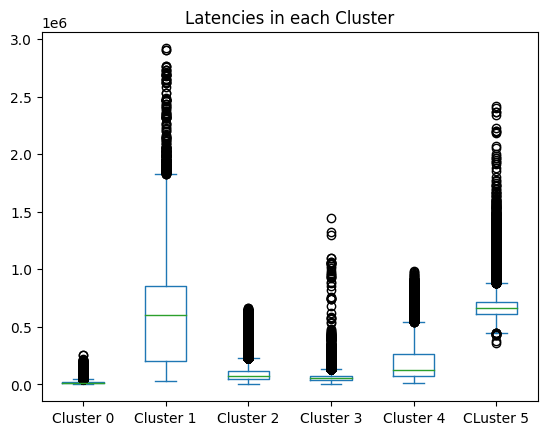

In [201]:
cluster_0 = merged_data[merged_data["Cluster"] == 0]
cluster_1 = merged_data[merged_data["Cluster"] == 1]
cluster_2 = merged_data[merged_data["Cluster"] == 2]
cluster_3 = merged_data[merged_data["Cluster"] == 3]
cluster_4 = merged_data[merged_data["Cluster"] == 4]
cluster_5 = merged_data[merged_data["Cluster"] == 5]
all_clusters = pd.concat([cluster_0['rtt_avg'], cluster_1['rtt_avg'], cluster_2['rtt_avg'], cluster_3['rtt_avg'], cluster_4['rtt_avg'], cluster_5['rtt_avg']], axis=1)
all_clusters.columns = ['Cluster 0','Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4', 'CLuster 5']
all_clusters.plot(kind="box", title="Latencies in each Cluster")
plt.show()

# Scratch Work

In [9]:
targets = data['target']
le = LabelEncoder()
data['target'] = le.fit_transform(data['target'])

In [11]:
X = data[['target', 'rtt_avg']].to_numpy()

In [12]:
X[:5]

array([[   84, 17906],
       [   49, 18635],
       [   84, 18074],
       [   49, 19000],
       [   79, 18359]])

In [13]:
kmeans = KMeans(n_clusters=5, random_state=0, n_init="auto").fit(X)

In [50]:
outputs = kmeans.predict(data[['target', 'rtt_avg']].to_numpy())

In [53]:
from collections import Counter
Counter(outputs)

Counter({0: 5127086, 2: 828987, 3: 3891, 1: 31965, 4: 31151})

In [63]:
data_new = data.copy(deep=True)

In [64]:
data_new['Cluster'] = data_new[['target', 'rtt_avg']].apply(lambda x: kmeans.predict([x])[0],axis=1)

In [65]:
data_new['Cluster'].unique().tolist()

[0, 2, 3, 1, 4]

In [68]:
data_new_2 = data.assign(Cluster = lambda x: kmeans.predict(x[['target', 'rtt_avg']].to_numpy()))

In [71]:
data_new_2['Cluster'].unique().tolist()

[0, 2, 3, 1, 4]

In [87]:
unit_id_map = pd.read_csv('202201/unit_id_mapping.csv')

In [88]:
merged_data = pd.merge(data_new_2, unit_id_map, how="left", on="unit_id")

In [105]:
merged_data['operator_name'] = pd.Categorical(merged_data.operator_name)
merged_data['operator_technology'] = pd.Categorical(merged_data.operator_technology)

In [106]:
merged_data.head()

,unit_id,dtime,target,rtt_avg,rtt_min,rtt_max,rtt_std,successes,failures,Cluster,operator_name,operator_technology
0,22,2022-01-01 00:28:36,84,17906,14043,27800,1651,711,0,0,Verizon,Fiber
1,22,2022-01-01 00:28:36,49,18635,16657,33193,2429,711,0,0,Verizon,Fiber
2,22,2022-01-01 00:52:23,84,18074,14834,26625,1569,220,0,0,Verizon,Fiber
3,22,2022-01-01 00:52:23,49,19000,16714,29388,2542,220,0,0,Verizon,Fiber
4,22,2022-01-01 01:28:34,79,18359,13986,33229,2249,271,0,0,Verizon,Fiber
